# Descrição de Atividade

Nesta atividade construiremos modelos preditivos de regressão em scikit learn para a predição dos votos de deputados federais considerando as últimas eleições. As atividades esperadas para essa etapa são descritas a seguir:

Baixe os dados [aqui](https://canvas.instructure.com/courses/1389733/files/69523670/download?verifier=A5EPvssqIQCjlxpWQyesLFer1VDTlRyTAAXR2iyi&wrap=1) (veja descrição dos dados mais abaixo).

Considere o pipeline mostrado nesse [link](https://www.kaggle.com/apapiu/regularized-linear-models) para construir seus modelos de regressão. 

Isso implica, dentre outras coisas:
1. Analisar as distribuições das variáveis para ver se estão enviesadas e precisam de correção;
2. Fazer tratamento de valores ausentes, variáveis categóricas e normalização, quando for o caso;
3. Construir modelos de regressão com (ridge e lasso) e sem regularização;
4. Considerar também modelos de regressão não paramétrica como KNN;
5. Considerar outros modelos ainda não vistos em sala de sua escolha (e.g. SVR, Regression Trees e Random Florests);
6. Tunar os hiperâmetros para cada caso e retornar os rmses de validação cruzada para todos os modelos avaliados;
7. Plotar os resíduos versus predições e analisar se esses plots representam bons indícios da adequabilidade dos modelos a esse problema;

Alguns dias antes da entrega final serão liberados os dados de teste referentes à 2014 para validação final dos seus melhores modelos.

_**Dica**: Uma coisa que você pode fazer é usar os dados de 2006 como treino e os de 2010 como validação. Uma vez encontrados os melhores modelos para 2010 junte 2006+2010, retreine, e aplique o modelo aos dados de 2014 que serão liberados._

## Responder:
### Dentre os modelos avaliados, qual foi o que deu o melhor resultado nos dados de 2014 em termos de RMSE? Justifique bem sua resposta.

A entrega deve ser um notebook Jupyter com código python e texto explicativo quando necessário. Crie um repositório na sua conta do github e envie o link do html do notebook.

**Sobre os dados**

Vamos explorar dados sobre as votações que candidatos à Câmara Federal de Deputados receberam nos anos de 2006 e 2010. Esses dados foram extraídos do [TSE](http://www.tse.jus.br/hotSites/pesquisas-eleitorais/index.html), pré-processados e contemplam informações sobre aproximadamente 7.300 candidatos. A descrição de cada atributo é dada mais abaixo.

* **sequencial_candidato**:  (character) id do candidato
* **nome**: (character)
* **uf**: (character)
* **partido**: (character)
* **quantidade_doacoes** : (integer)
* **quantidade_doadores**: (integer) numero de doadores diferentes
* **total_receita**: (double) soma em reais das doacoes
* **media_receita**: (double) media das doacoes
* **recursos_de_outros_candidatos_por_comite**: (double) quantia em reais das doacoes provenientes de outros candidatos ou comite partidário
* **recursos_de_pessoas_fisicas**: (double) quantia em reais das doacoes provenientes de outros CPFs
* **recursos_de_pessoas_juridicas**: (double) quantia em reais das doacoes provenientes de outros CNPJ
* **recursos_proprios**: (double) quantia em reais das doacoes provenientes do proprio candidato
* **recursos_de_partido_politico**: (double) quantia em reais das doacoes provenientes do partido politico do candidato
* **votos**: (integer) variavel alvo. Se refere ao numero de votos na campanha de 2006 e 2010
* **quantidade_despesas**: (integer)
* **quantidade_fornecedores**: (integer) numero de fornecedores por despesas diferentes
* **total_despesa**: (double) soma em reais das despesas de campanha
* **media_despesa**: (double) media das despesas de campanha
* **cargo**: (character)
* **sexo**:  (character)
* **grau**: (character) grau de instrucao do candidato
* **estado_civil**: (character)
* **ocupacao**: (character) ocupacao do candidato

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

sns.set(style="ticks")

%matplotlib inline

## Load Data

In [2]:
candidates_df = pd.read_csv('../data/eleicoes_2006_a_2010.csv')
candidates_df.shape

(7330, 23)

### Split Train and Test Data

In [3]:
candidates_df = candidates_df.drop(columns=['sequencial_candidato', 'nome'])

## EDA - Exploratory Data Analysis

Inicialmente, devemos fazer uma análise exploratória dos dados para descobrir como eles estão distribuídos, se possuem valores extraordinários (outliers) e se tem alguma correlação mais forte entre si, especialmente com a variável alvo (**votos**).

In [4]:
candidates_df.columns

Index(['ano', 'uf', 'partido', 'quantidade_doacoes', 'quantidade_doadores',
       'total_receita', 'media_receita',
       'recursos_de_outros_candidatos_comites', 'recursos_de_pessoas_fisicas',
       'recursos_de_pessoas_juridicas', 'recursos_proprios',
       'quantidade_despesas', 'quantidade_fornecedores', 'total_despesa',
       'media_despesa', 'cargo', 'sexo', 'grau', 'estado_civil', 'ocupacao',
       'votos'],
      dtype='object')

In [5]:
candidates_df.describe(exclude=['category', 'object'])

,ano,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos_comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,votos
count,7330.000000,7330.000000,7330.000000,7.169000e+03,7169.000000,4.940000e+03,4.647000e+03,3.354000e+03,4.942000e+03,7330.000000,7330.000000,7.330000e+03,7330.000000,7.330000e+03
mean,2008.151160,28.310095,25.817462,1.544899e+05,5485.597708,3.002116e+04,3.730931e+04,1.761195e+05,3.914169e+04,133.339836,110.179945,1.588707e+05,1500.033736,2.280617e+04
std,1.994416,118.655091,103.659438,3.953880e+05,14116.531491,1.280932e+05,8.215398e+04,3.517541e+05,1.839980e+05,416.838801,338.493008,3.951814e+05,6363.830635,4.810133e+04
min,2006.000000,1.000000,1.000000,0.000000e+00,0.000000,2.410000e+00,3.000000e-02,0.000000e+00,0.000000e+00,1.000000,1.000000,0.000000e+00,0.000000,2.000000e+00
25%,2006.000000,4.000000,4.000000,2.700000e+03,622.857143,1.180000e+03,2.000000e+03,3.422500e+03,1.177233e+03,6.000000,5.000000,2.781405e+03,398.452936,8.600000e+02
50%,2010.000000,9.000000,8.000000,1.209578e+04,1540.542500,3.522570e+03,9.000000e+03,2.612000e+04,5.000000e+03,21.000000,18.000000,1.297986e+04,794.678212,3.025000e+03
75%,2010.000000,24.000000,22.000000,8.929956e+04,4662.500000,1.327550e+04,3.756234e+04,1.755218e+05,2.027459e+04,83.000000,71.000000,1.006515e+05,1564.290552,2.027450e+04
max,2010.000000,6997.000000,5800.000000,4.539727e+06,500180.000000,3.664205e+06,1.403049e+06,3.178226e+06,5.525600e+06,9932.000000,8359.000000,4.989491e+06,500177.000000,1.353820e+06


A tabela acima já nos permite tirar uma série de insights sobre os dados que temos, entretando precisamos investigar a existência de valores estranhos no nosso dataset, como valores não-numéricos (NaN) em variáveis numéricas:

In [6]:
for col in candidates_df.columns:
    amount_nan = candidates_df[str(col)].isna().sum()
    if amount_nan > 0:
        print("Column [{:02}]: {:40} - Amount NaN: {}".format(candidates_df.columns.get_loc(str(col)), str(col), amount_nan))

Column [05]: total_receita                            - Amount NaN: 161
Column [06]: media_receita                            - Amount NaN: 161
Column [07]: recursos_de_outros_candidatos_comites    - Amount NaN: 2390
Column [08]: recursos_de_pessoas_fisicas              - Amount NaN: 2683
Column [09]: recursos_de_pessoas_juridicas            - Amount NaN: 3976
Column [10]: recursos_proprios                        - Amount NaN: 2388


Para essas variáveis não podemos ter valores não numéricos, então vamos colocar esses valores para 0.0, uma vez que são valores de receita e recursos.

In [7]:
candidates_df.total_receita.fillna(0, inplace=True)
candidates_df.media_receita.fillna(0, inplace=True)
candidates_df.recursos_de_outros_candidatos_comites.fillna(0, inplace=True)
candidates_df.recursos_de_pessoas_fisicas.fillna(0, inplace=True)
candidates_df.recursos_de_pessoas_juridicas.fillna(0, inplace=True)
candidates_df.recursos_proprios.fillna(0, inplace=True)

### Calculando Skewness de Variáveis Numéricas

Aqui nós transformamos skewed features para que tenham uma distribuição mais normalizada. Ter uma distribuição mais normalizada nos garante um maior arsenal de ferramentas estatísticas e computacionais que podemos utilizar, assim como torna a análise dos dados mais conveniente para nós.

Nós utilizamos o **log(1 + x)** em vez de apenas **log(x)**, uma vez que o log de 0 não existe, e várias de nossas variáveis tem esses valores, como as que preenchemos em substituição a NaN na seção acima. Além disso, como estamos lidando com valores de receita, despesa, etc. é comum ter valores 0 em nossas distribuições.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd70ab41390>,
      dtype=object)

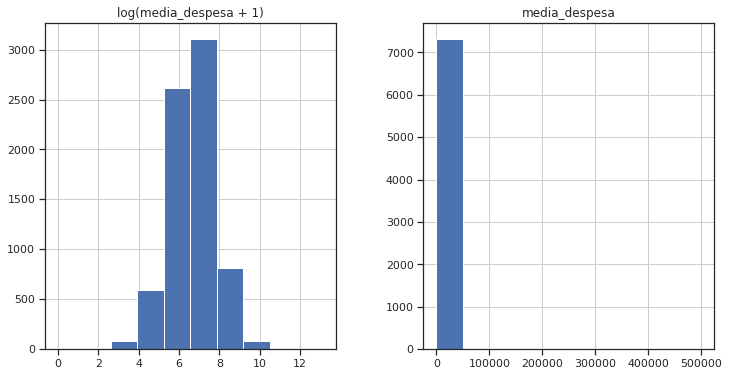

In [8]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
media_despesa = pd.DataFrame({"media_despesa" : candidates_df["media_despesa"], "log(media_despesa + 1)" : np.log1p(candidates_df["media_despesa"])})
media_despesa.hist()

In [9]:
numeric_features = candidates_df.dtypes[candidates_df.dtypes != 'object'].index

skewed_feats = candidates_df[numeric_features].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

print(skewed_feats)

candidates_df[skewed_feats] = np.log1p(candidates_df[skewed_feats])

Index(['quantidade_doacoes', 'quantidade_doadores', 'total_receita',
       'media_receita', 'recursos_de_outros_candidatos_comites',
       'recursos_de_pessoas_fisicas', 'recursos_de_pessoas_juridicas',
       'recursos_proprios', 'quantidade_despesas', 'quantidade_fornecedores',
       'total_despesa', 'media_despesa', 'votos'],
      dtype='object')


Importante notar que a variável-alvo **_votos_** também está incluída no conjunto de skewed variables, e não precisa ser transformada em separado.

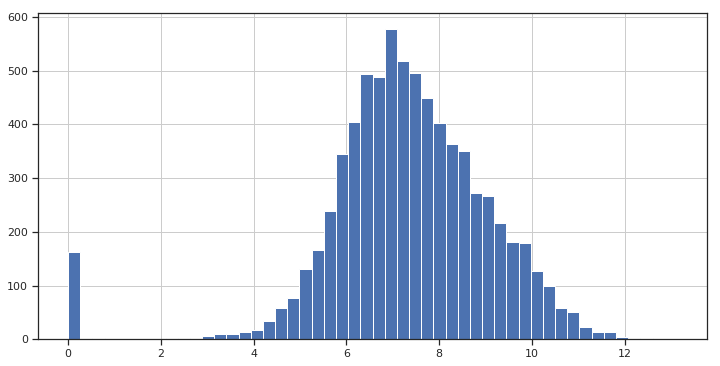

In [10]:
candidates_df.media_receita.hist(bins=50)

### Variáveis Categóricas

Como estamos trabalhando com modelos que apenas aceitam variáveis numéricas, precisamos também transformar variáveis categóricas do nosso dataset em variáveis numéricas com as quais nosso modelo de machine learning pode trabalhar. As variáveis não-numéricas (categóricas) que temos são as seguintes:

In [11]:
cat_variables = []

for col in candidates_df.columns:
    if not np.issubdtype(candidates_df[str(col)].dtype, np.number) and col != 'nome':
        cat_variables.append(col)
        print("Column [{:02}]: {:40}".format(candidates_df.columns.get_loc(str(col)), str(col)))

Column [01]: uf                                      
Column [02]: partido                                 
Column [15]: cargo                                   
Column [16]: sexo                                    
Column [17]: grau                                    
Column [18]: estado_civil                            
Column [19]: ocupacao                                


Vamos verificar a distribuição dessas variáveis, exceto **nome**, para entender como e se podemos transformar todas para um valor inteiro.

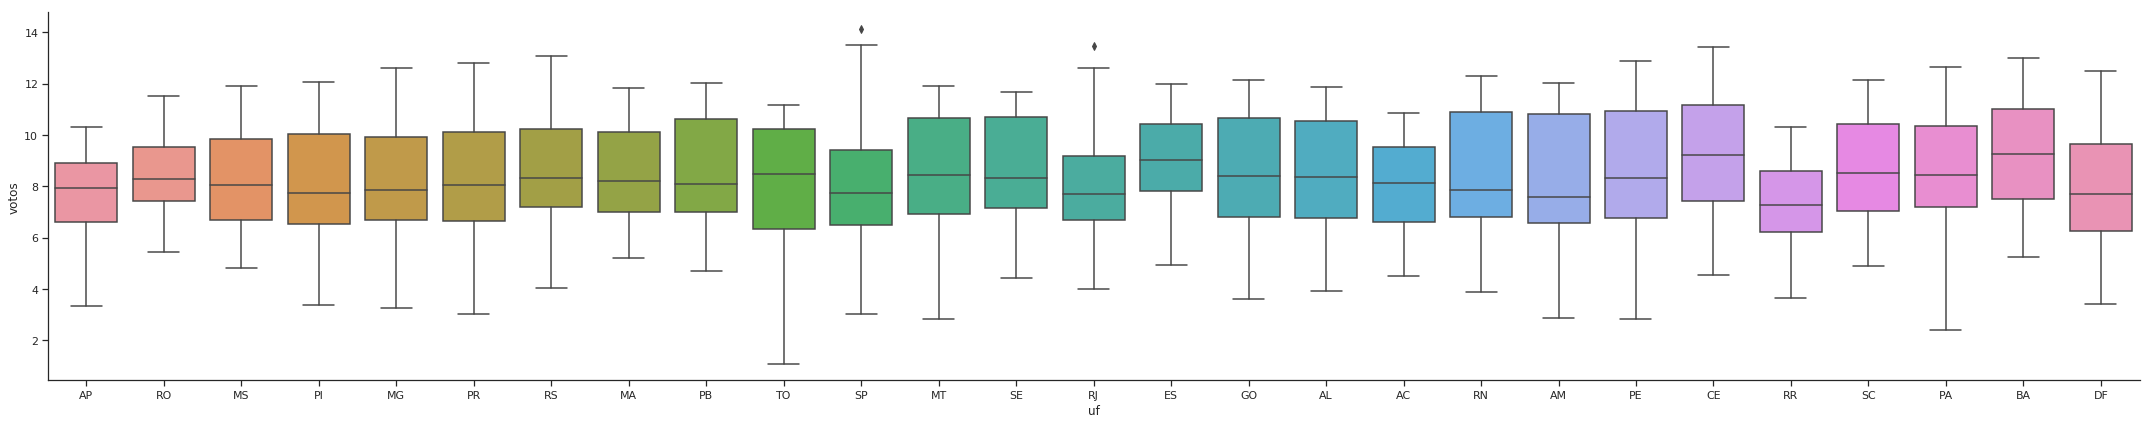

In [12]:
sns.catplot(x='uf', y='votos', data=candidates_df, aspect=5, height=6, kind='box')

Aqui podemos aplicar uma função e transformar cada estado para um código numérico:

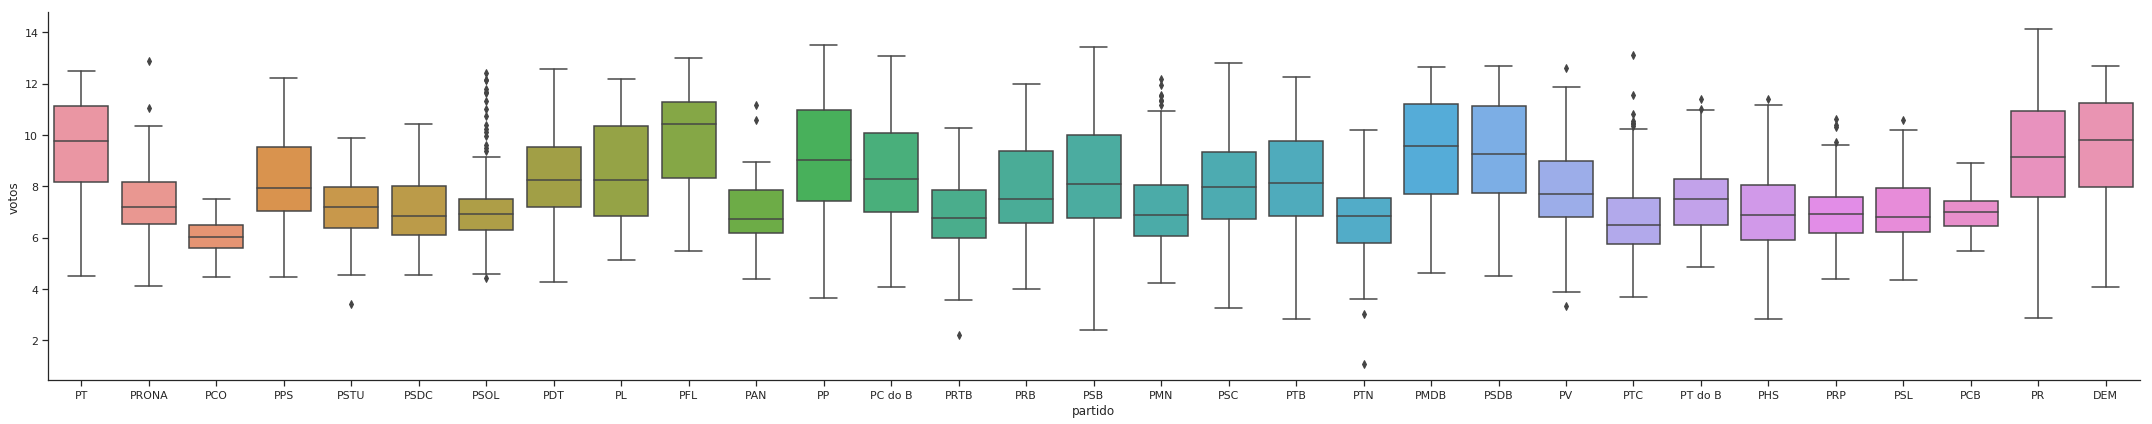

In [13]:
sns.catplot(x='partido', y='votos', data=candidates_df, aspect=5, height=6, kind='box')

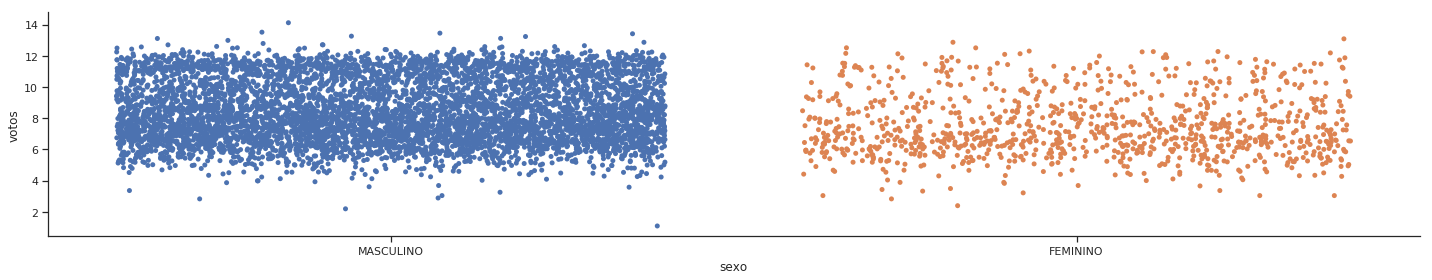

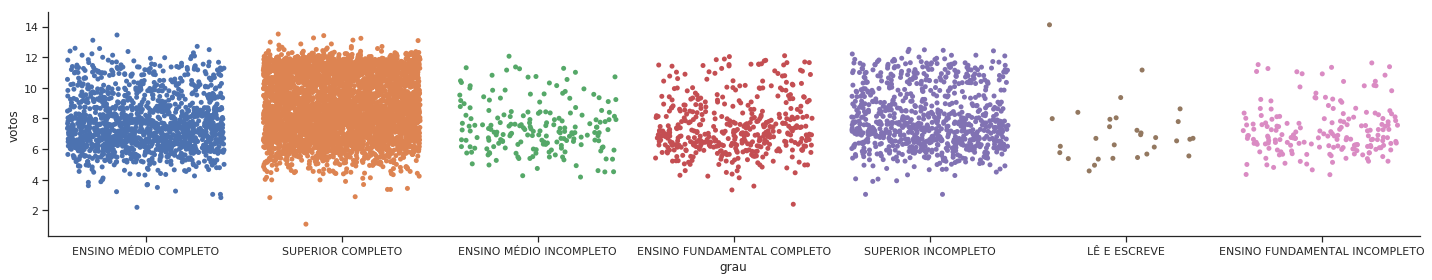

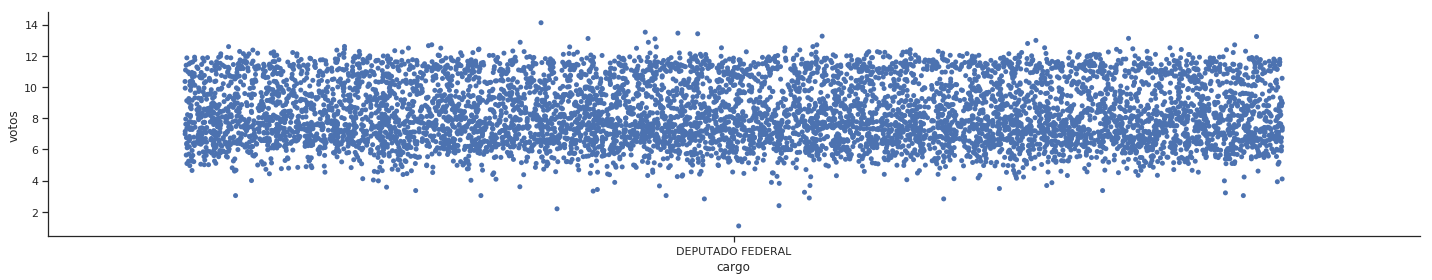

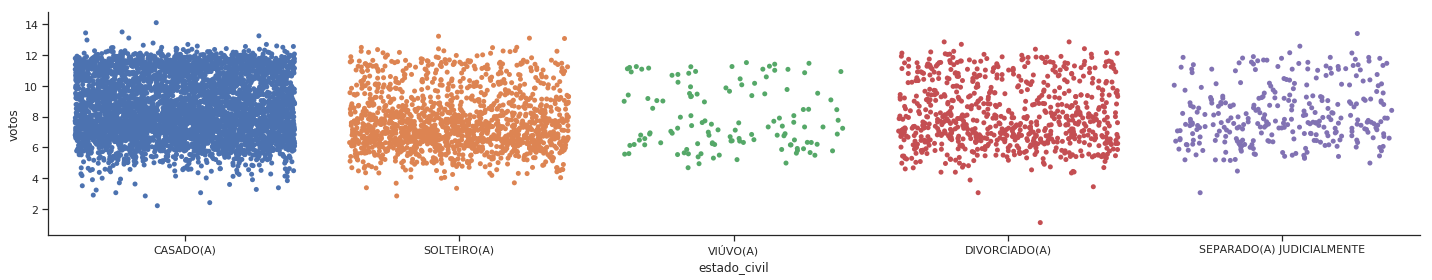

In [14]:
for col in ['sexo', 'grau', 'cargo', 'estado_civil']:
    sns.catplot(x=col, y='votos', data=candidates_df, jitter=.4, aspect=5, height=4)

Note que podemos tratar a variável **grau** como uma variável ordinária:

In [15]:
cleanup_nums = {"grau" : {"LÊ E ESCREVE": 1, 
                       "ENSINO FUNDAMENTAL INCOMPLETO":2, 
                       "ENSINO FUNDAMENTAL COMPLETO":3, 
                       "ENSINO MÉDIO INCOMPLETO":4,
                       "ENSINO MÉDIO COMPLETO":5,
                       "SUPERIOR INCOMPLETO":6,
                       "SUPERIOR COMPLETO": 7}}
candidates_df.replace(cleanup_nums, inplace=True)

candidates_df.grau.head()

0    5
1    7
2    7
3    4
4    3
Name: grau, dtype: int64

Para a variável **ocupacao** nós temos um conjunto muito grande de diferentes valores, o que inviabiliza a exposição gráfica de todos os valores, entretando nós expomos aqui as quantidades para as 20 ocupações mais comuns:

In [16]:
candidates_df.ocupacao.value_counts().head(20)

OUTROS                                            819
DEPUTADO                                          703
ADVOGADO                                          673
EMPRESÁRIO                                        629
VEREADOR                                          326
MÉDICO                                            325
COMERCIANTE                                       316
SERVIDOR PÚBLICO ESTADUAL                         248
SERVIDOR PÚBLICO FEDERAL                          214
PROFESSOR DE ENSINO MÉDIO                         172
ADMINISTRADOR                                     160
ENGENHEIRO                                        158
APOSENTADO (EXCETO SERVIDOR PÚBLICO)              153
POLICIAL MILITAR                                  149
PROFESSOR DE ENSINO SUPERIOR                      148
SERVIDOR PÚBLICO MUNICIPAL                        123
ESTUDANTE, BOLSISTA, ESTAGIÁRIO E ASSEMELHADOS     85
MILITAR REFORMADO                                  80
ECONOMISTA                  

### Dummy Variables

Para transformar essas variáveis categóricas em numéricas (dummy variables), utilizamos uma função especial da biblioteca _pandas_:

In [17]:
print(cat_variables)
candidates_df = pd.get_dummies(data=candidates_df, columns=cat_variables)
candidates_df.shape

['uf', 'partido', 'cargo', 'sexo', 'grau', 'estado_civil', 'ocupacao']


(7330, 262)

### Distribuição de Variáveis Numéricas

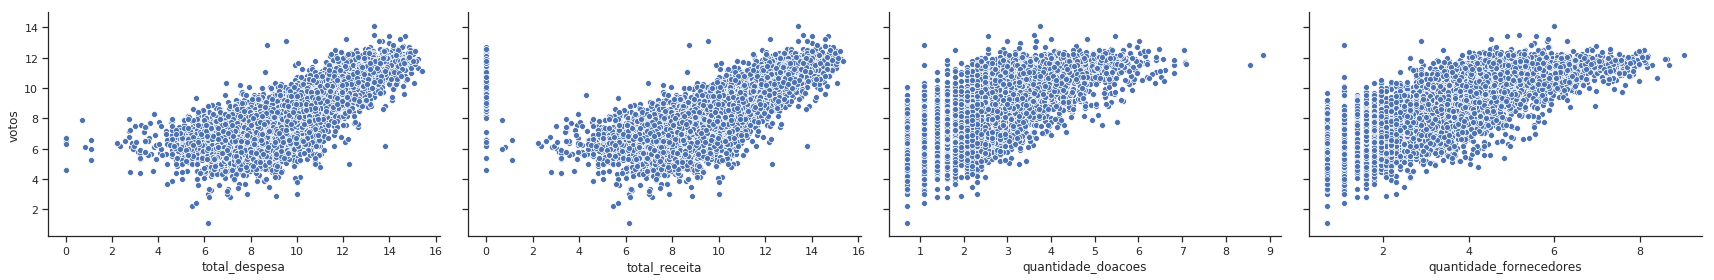

In [18]:
sns.pairplot(candidates_df, x_vars=['total_despesa', 'total_receita', 'quantidade_doacoes', 'quantidade_fornecedores'], y_vars=['votos'], aspect=1.5, height=4)

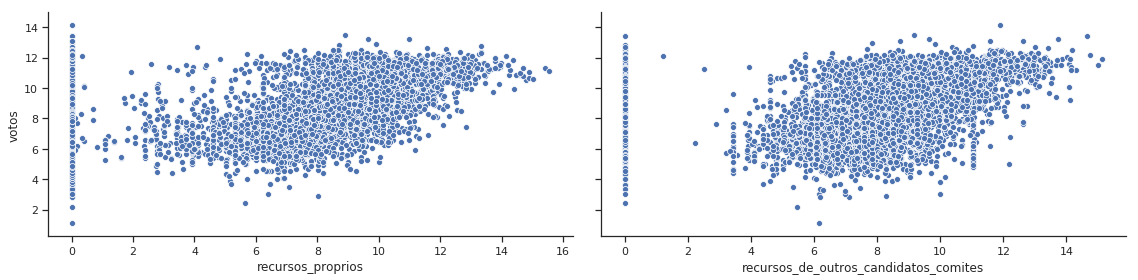

In [19]:
sns.pairplot(candidates_df, x_vars=['recursos_proprios', 'recursos_de_outros_candidatos_comites'], y_vars=['votos'], aspect=2, height=4)

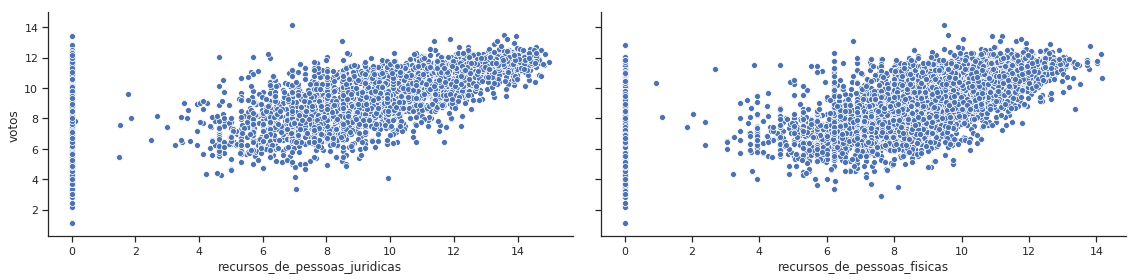

In [20]:
sns.pairplot(candidates_df, x_vars=['recursos_de_pessoas_juridicas', 'recursos_de_pessoas_fisicas'], y_vars=['votos'], aspect=2, height=4)

## Models

In [21]:
candidates_train = candidates_df[candidates_df.ano == 2006]
candidates_val = candidates_df[candidates_df.ano == 2010]

feats = candidates_df.columns[candidates_df.columns != 'votos']

X_train = candidates_train[feats]
y_train = candidates_train['votos']

X_val = candidates_val[feats]
y_val = candidates_val['votos']

Aqui nós vamos usar testar alguns modelos de regressão do scikit-learn em nosso dataset sem usar regularização (ridge e lasso) e em seguida utilizando.

Mas primeiro vamos usar uma função criada por [Alexandru Papiu - Regularized Linear Models](https://www.kaggle.com/apapiu/regularized-linear-models) para analisar os erros dos modelos propostos. A função utiliza validação cruzada com k = 5 (k-fold validation) e como função de score Negative Mean Squared Error.

In [22]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, LinearRegression
from sklearn.model_selection import cross_val_score

def rmse_cv_train(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

def rmse_cv_val(model):
    rmse = np.sqrt(-cross_val_score(model, X_val, y_val, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

### Sem Regularização


In [23]:
lr = LinearRegression().fit(X_train, y_train)
rmse_cv_train(lr).mean()

715623343.2260275

Média de Erros nos dados de validação

In [24]:
rmse_cv_val(lr).mean()

78997894433.98712

Como podemos observar, os valores de RMSE para um modelo linear multivariado sem regularização tem um erro bastante elevado. Isso provavelmente se deve ao fato de está acontecendo overfitting. Uma simples olhada na ordem dos coeficientes do modelo nos permite observar isso. Caso os coeficientes sejam muito grandes, temos overfitting.

/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


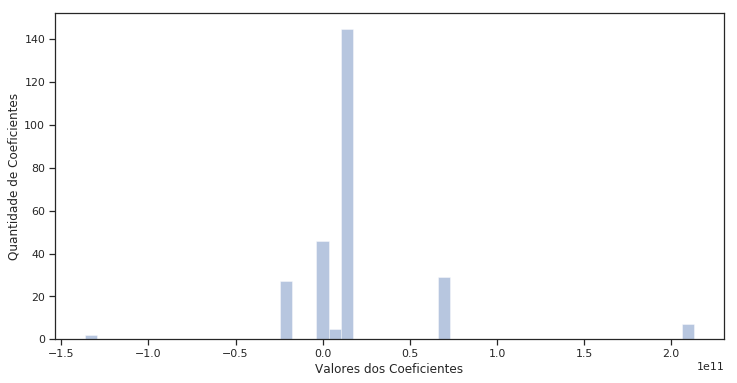

In [25]:
coefs = lr.coef_
ax = sns.distplot(coefs, kde=False)
ax.set(xlabel='Valores dos Coeficientes', ylabel='Quantidade de Coeficientes')
plt.show()

##### **Plot Resíduos vs Predições - Linear Regressor**

Abaixo nós plotamos o gráfico de resíduos vs predições. Ele nos possibilita visualizar o quão eficiente nosso modelo é para capturar a variância de nossos dados e representá-los de maneira adequada. O mais próximo que os valores de resíduos estiverem da linha demarcada (0), melhor será o nosso modelo.

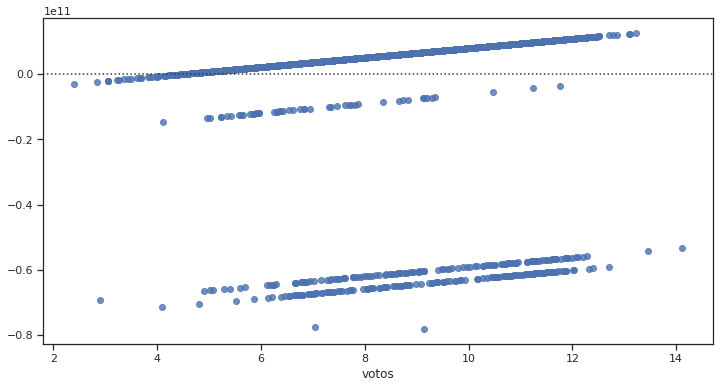

In [26]:
predictions = lr.predict(X_val)
sns.residplot(y_val, predictions)

Como vemos, nosso modelo feito com um Linear Regressor sem regularização não é um bom preditor: nós não observamos padrões visuais surgindo na distribuição dos resíduos, o que é um mal indício de adequabilidade do modelo, existem características que não estão sendo corretamente capturadas. E também os pontos estão concentrados aleatoriamente ao redor da linha nula (0).

### Com Regularização

#### Ridge

Text(0,0.5,'rmse')

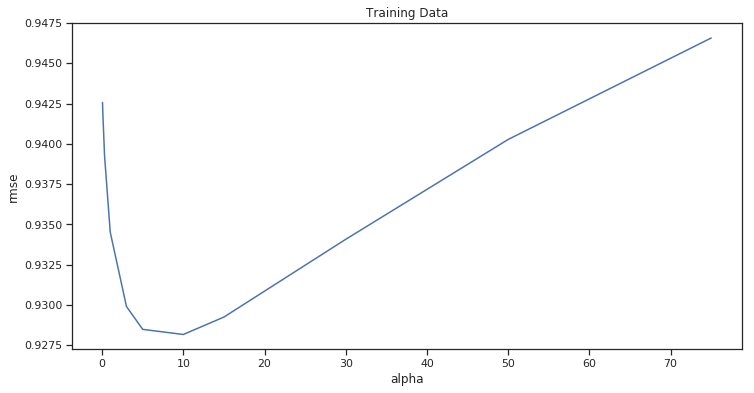

In [27]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge_train = [rmse_cv_train(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

cv_ridge_train = pd.Series(cv_ridge_train, index = alphas)

cv_ridge_train.plot(title = "Training Data")
plt.xlabel("alpha")
plt.ylabel("rmse")

O valor de **alpha** associado com o menor RMSE é **10**. Então vamos utilizar esse valor para configurar nosso modelo de regressão linear Ridge, o qual utiliza normalização **l2**. O valor de RMSE encontrado para alpha = 10 é em torno de 0.928.

In [52]:
cv_ridge_train.min()

0.9281697731979219

Média dos erros nos dados de validação

In [53]:
ridge = Ridge(alpha = 10).fit(X_train, y_train)
rmse_cv_val(ridge).mean()

0.9917284417581339

##### **Plot Resíduos vs Predições - Ridge**

Abaixo nós plotamos o gráfico de resíduos vs predições. Ele nos possibilita visualizar o quão eficiente nosso modelo é para capturar a variância de nossos dados e representá-los de maneira adequada. O mais próximo que os valores de resíduos estiverem da linha demarcada (0), melhor será o nosso modelo.

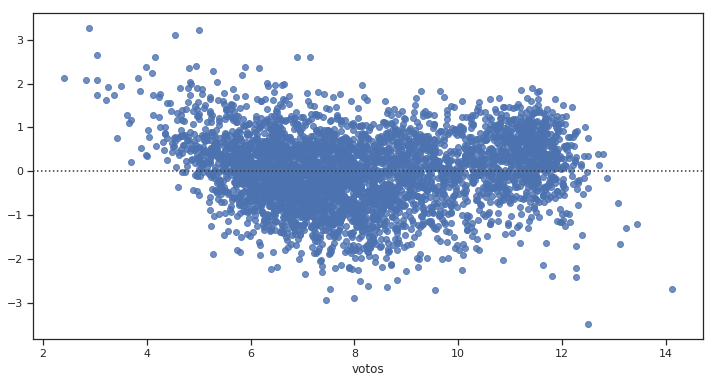

In [31]:
predictions = ridge.predict(X_val)
sns.residplot(y_val, predictions)

Como vemos, nosso modelo Ridge é um regressor razoável: nós não observamos nenhum padrão visual na distribuição dos resíduos, o que é um bom indício de adequabilidade do modelo. E também os pontos estão concentrados próximos a linha nula (0).

#### Lasso

In [32]:
model_lasso = LassoCV(alphas = [1, 5e-1, 1e-1, 5e-2, 1e-3, 1e-4, 1e-5, 1e-6], max_iter=1e5).fit(X_train, y_train)
rmse_cv_train(model_lasso).mean()

0.9288344487702895

Média dos erros no dados de validação

In [33]:
rmse_cv_val(model_lasso).mean()

0.9888126761794419

O modelo Lasso se sai um pouco melhor que o modelo Ridge. Complementando a análise, podemos identificar quais variáveis foram consideradas ou eliminadas pelo modelo de regressão Lasso.

In [34]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 101 variables and eliminated the other 160 variables


Text(0.5,1,'Coefficients in the Lasso Model')

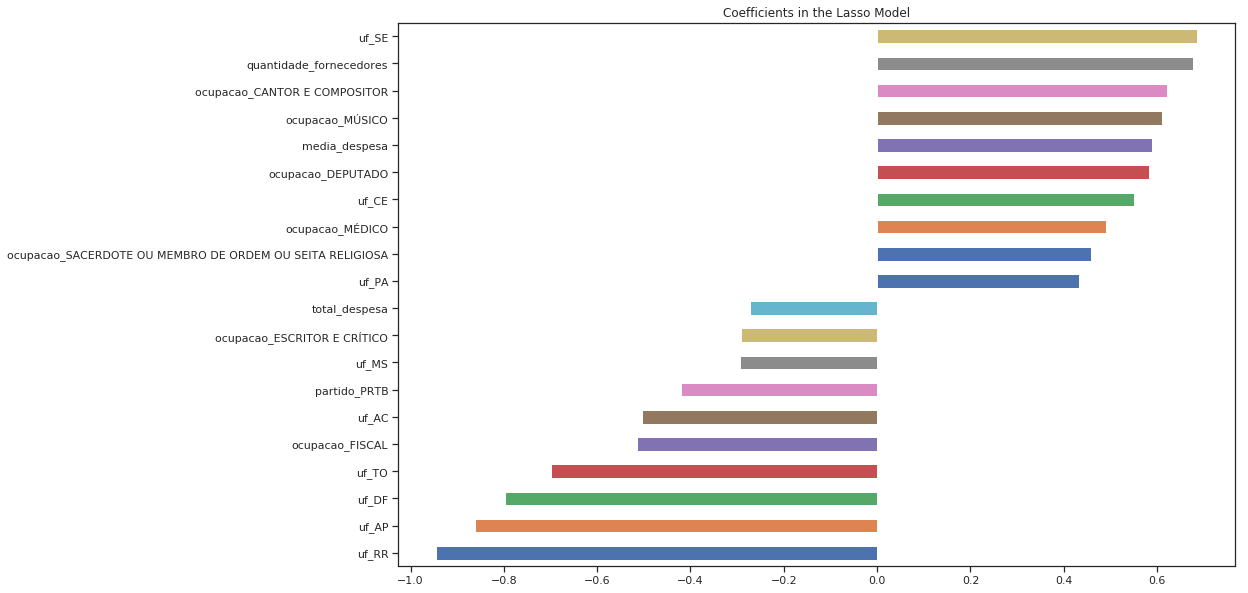

In [35]:
imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])

matplotlib.rcParams['figure.figsize'] = (15.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

Como podemos ver, o modelo Ridge consegue se sair melhor com o nosso dataset do que o modelo Lasso. O modelo Lasso eliminou um total de 157 variáveis e considerou 104 variáveis como mais importantes.

O gráfico acima também nos permite visualizar que a variável considerada mais relevante para o modelo de predição é **quantidade_doadores**, o que faz bastante sentido. Outra variável também bastante relevante é **ocupacao_DEPUTADO**, o que também faz sentido visto que a pessoa está tentando uma reeleição e provavelmente já é conhecido, tem uma base eleitoral, etc.

Outras variáveis, que o modelo curiosamente considera como uma contribuição negativa para a arrecadação de votos, são **sexo_FEMININO** e **total_receita**. Algumas hipóteses podem ser levantadas, embora ainda se precise de maiores avaliações:

1. Existe uma barreira ou uma resistência quanto à entrada de mulheres na política, isso pode se comprovar na própria composição do nosso congresso nacional, o qual tem um número muito baixo de mulheres;
2. A receita de campanha de um deputado contribui negativamente para a obtenção de votos. Isso é algo que precisa ser investigado em mais profundidade, mas que foge do escopo desse exercício.

##### **Plot Resíduos vs Predições - Lasso**

Abaixo nós plotamos o gráfico de resíduos vs predições. Ele nos possibilita visualizar o quão eficiente nosso modelo é para capturar a variância de nossos dados e representá-los de maneira adequada. O mais próximo que os valores de resíduos estiverem da linha demarcada (0), melhor será o nosso modelo.

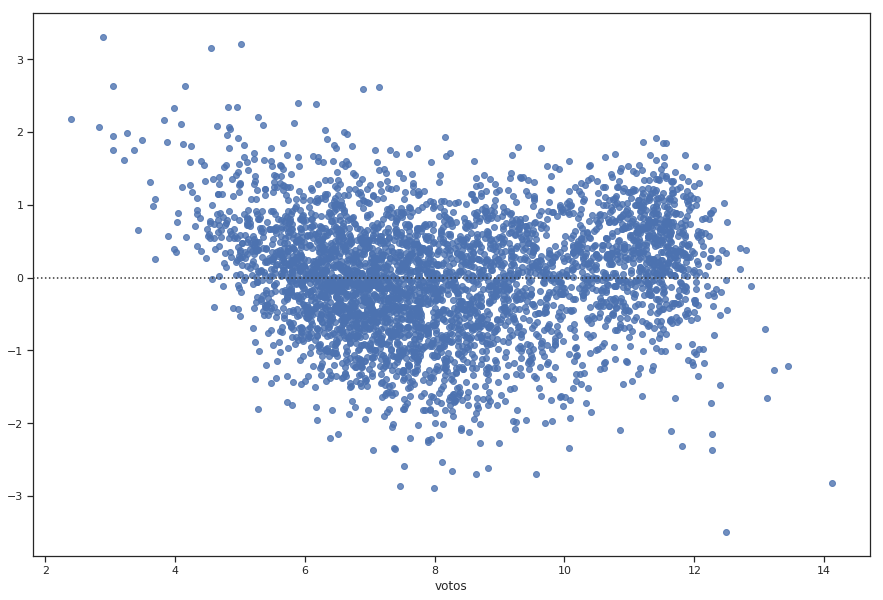

In [37]:
predictions = model_lasso.predict(X_val)
sns.residplot(y_val, predictions)

Como vemos, nosso modelo Lasso é um regressor razoável: nós não observamos nenhum padrão visual na distribuição dos resíduos, o que é um bom indício de adequabilidade do modelo. E também os pontos estão concentrados próximos a linha nula (0).

### Non-Parameterized Models

#### KNN (K-Nearest Neighbors)

In [38]:
from sklearn.neighbors import KNeighborsRegressor

reg = KNeighborsRegressor(n_neighbors = 15)
reg.fit(X_train, y_train)

predictions_set = reg.predict(X_val)

print("Validation set predictions: \n{}".format(predictions_set))
print("Validation set R²: {:.2f}".format(reg.score(X_val, y_val)))

Validation set predictions: 
[10.1931258   7.25000262  6.89517192 ...  7.36333827  7.59323257
  8.84785494]
Validation set R²: 0.72


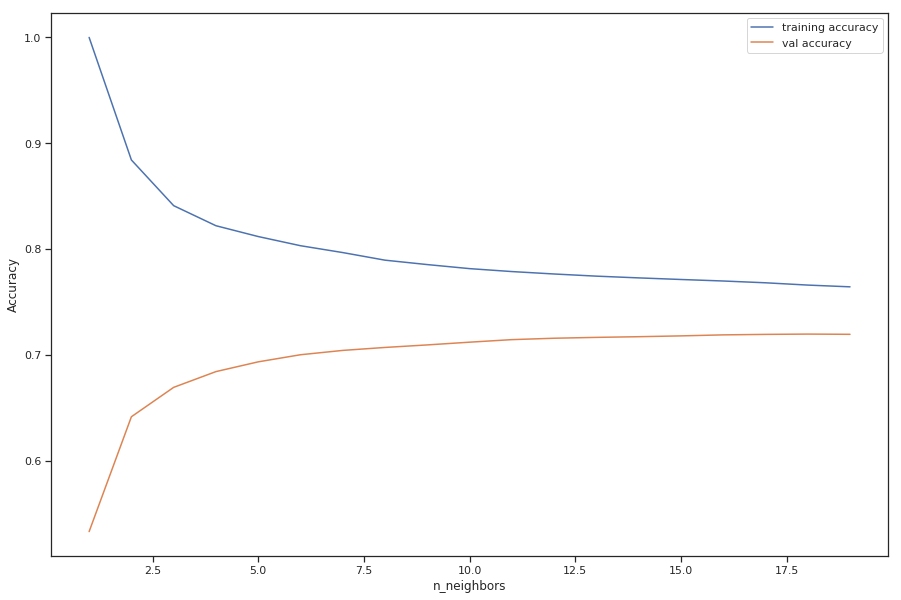

In [39]:
training_accuracy = []
val_accuracy = []

neighbors_settings = range(1, 20)

for n_neighbors in neighbors_settings:
    knr = KNeighborsRegressor(n_neighbors=n_neighbors)
    knr.fit(X_train, y_train)
    training_accuracy.append(knr.score(X_train, y_train))
    val_accuracy.append(knr.score(X_val, y_val))
    
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, val_accuracy, label="val accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

Aparentemente, o melhor número para K é 15, a partir do qual, os valores de acurácia começam a se repetir. Vamos fazer a análise utilizando as funções para cálculo de RMSE:

In [40]:
knr = KNeighborsRegressor(n_neighbors = 15).fit(X_train, y_train)

print("RMSE train: {}".format(rmse_cv_train(knr).mean()))
print("RMSE validation: {}".format(rmse_cv_val(knr).mean()))

RMSE train: 0.987112477235946
RMSE validation: 1.0226696614154196


##### **Plot Resíduos vs Predições - KNN**

Abaixo nós plotamos o gráfico de resíduos vs predições. Ele nos possibilita visualizar o quão eficiente nosso modelo é para capturar a variância de nossos dados e representá-los de maneira adequada. O mais próximo que os valores de resíduos estiverem da linha demarcada (0), melhor será o nosso modelo.

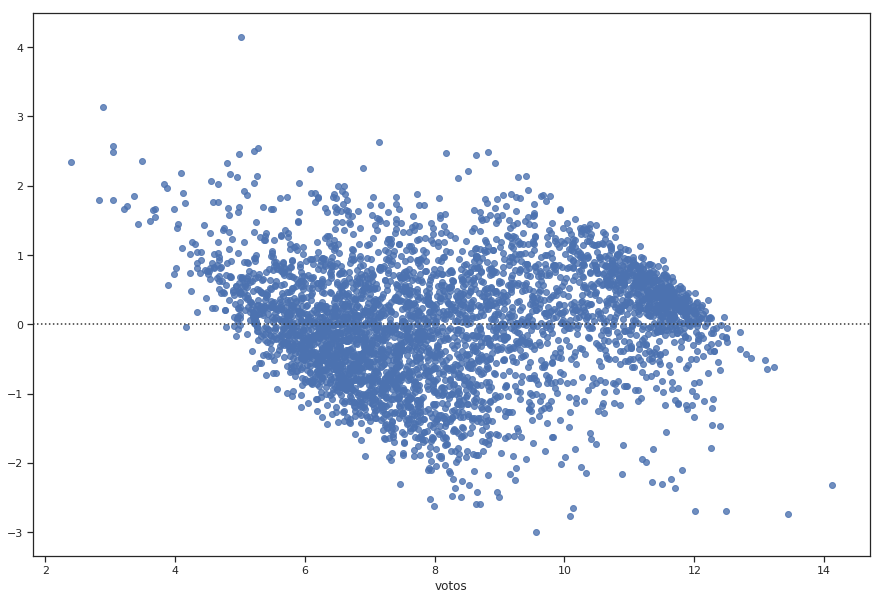

In [41]:
sns.residplot(y_val, predictions_set)

Como vemos, nosso modelo K-Nearest Regressor não é tão bom, o que é corroborado também pelo valor do R² que é de 0.72, ou seja, apenas 72% da variância dos dados é explicada pelo nosso modelo e pelas variáveis que ele considera. Entretanto, não observamos nenhum padrão visual na distribuição dos resíduos, o que é um bom indício de adequabilidade do modelo.

### Modelos Extra

Nessa sessão vamos testar a eficiência em termos de Precision, Recall e F-Score, quando utilizamos um Ensemble Random Forest Regressor.

In [48]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(random_state = 2).fit(X_train, y_train)

print("RMSE Train: {}".format(rmse_cv_train(regr).mean()))
print("RMSE Validation: {}".format(rmse_cv_val(regr).mean()))
print("R²: {}".format(regr.score(X_val, y_val)))

RMSE Train: 0.9743654810616611
RMSE Validation: 0.9875097437176761
R²: 0.6985695285832014


##### **Plot Resíduos vs Predições - KNN**

Abaixo nós plotamos o gráfico de resíduos vs predições. Ele nos possibilita visualizar o quão eficiente nosso modelo é para capturar a variância de nossos dados e representá-los de maneira adequada. O mais próximo que os valores de resíduos estiverem da linha demarcada (0), melhor será o nosso modelo.

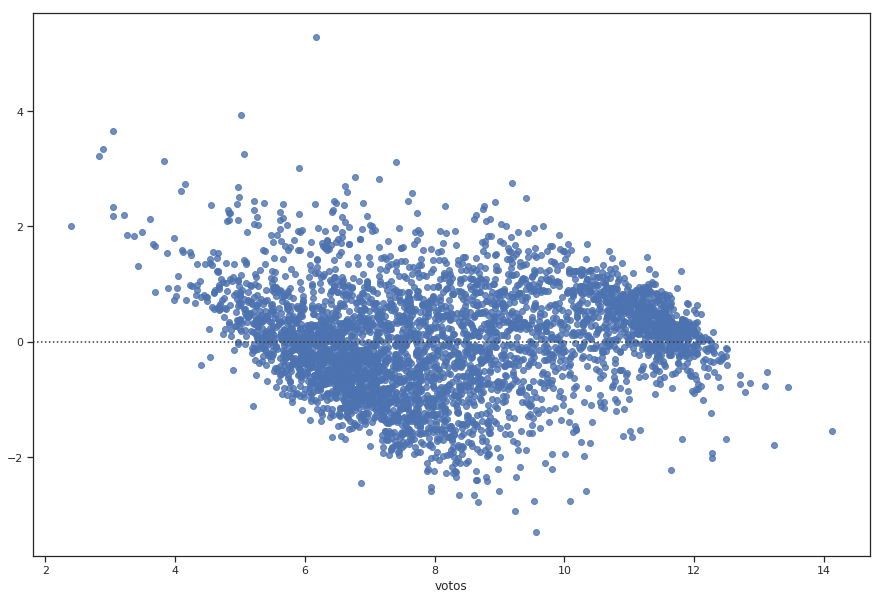

In [49]:
regr_predictions = regr.predict(X_val)
sns.residplot(y_val, regr_predictions)

Como vemos, nosso modelo **Random Forest Regressor** é tão bom quanto o KNN em termos de R², mas em termos de média de RMSE utilizando validação cruzada sobre os dados de validação, é o melhor modelo que encontramos até agora.

## Usando Workflows Scikit Learn

In [76]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn import tree


# Construct some pipelines
pipe_lr = Pipeline([('scl', StandardScaler()),
                ('reg', LinearRegression())])

pipe_rf = Pipeline([('scl', StandardScaler()),
                ('reg', RandomForestRegressor(random_state=2))])

pipe_lasso = Pipeline([('scl', StandardScaler()),
                ('reg', LassoCV())])

pipe_ridge = Pipeline([('scl', StandardScaler()),
                ('reg', RidgeCV())])

pipe_knn = Pipeline([('scl', StandardScaler()),
                    ('reg', KNeighborsRegressor())])

param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
param_range_fl = [1.0, 0.5, 0.1]

grid_params_lr = [{}] 

grid_params_lasso = [{'reg__alphas' : [1, 5e-1, 1e-1, 5e-2, 1e-3, 1e-4, 1e-5, 1e-6],
                      'reg__max_iter' : [1e5]}]

grid_params_ridge = [{'reg_alphas' : [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]}]

grid_params_rf = [{'reg__min_samples_leaf': param_range,
            'reg__max_depth': param_range,
            'reg__min_samples_split': param_range[1:]}]

grid_params_knn = [{'reg__n_neighbors' : [x for x in range(1,21)]}]

# Construct grid searches
jobs = -1

gs_lr = GridSearchCV(estimator = pipe_lr,
                param_grid = grid_params_lr,
                scoring = 'neg_mean_squared_error',
                cv = 10) 

gs_rf = GridSearchCV(estimator = pipe_rf,
                param_grid = grid_params_rf,
                scoring = 'neg_mean_squared_error',
                cv = 10, 
                n_jobs = jobs)

gs_lasso = GridSearchCV(estimator = pipe_lasso,
                       param_grid = grid_params_lasso,
                       scoring = 'neg_mean_squared_error',
                       cv = 10,
                       n_jobs = jobs)

gs_ridge = GridSearchCV(estimator = pipe_ridge,
                       param_grid = grid_params_ridge,
                       scoring = 'neg_mean_squared_error',
                       cv = 10,
                       n_jobs = jobs)

gs_knn = GridSearchCV(estimator = pipe_knn,
                     param_grid = grid_params_knn,
                     scoring = 'neg_mean_squared_error',
                     cv = 10,
                     n_jobs = jobs)

# List of pipelines for ease of iteration
grids = [gs_lr, gs_rf, gs_lasso, gs_ridge, gs_knn]

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0: 'Logistic Regression', 1: 'Random Forest', 
            2: 'Lasso', 3: 'Ridge', 
            4: 'KNN'}


# Fit the grid search objects
print('Performing model optimizations...')
best_rmse = 0.0
best_reg = 0
best_gs = ''
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    # Fit grid search
    gs.fit(X_train, y_train)

    # Best params
    print('Best params: %s' % gs.best_params_)
    
    # Best training data accuracy
    print('Best training negative mean squared error: %.3f' % gs.best_score_)
    
    # Predict on test data with best params
    y_pred = gs.predict(X_val)
    
    # Validation data accuracy of model with best params
    print('Validation set RMSE for best params: %.3f ' % mean_squared_error(y_val, y_pred))
    
    # Track best (highest test accuracy) model
    if mean_squared_error(y_val, y_pred) > best_acc:
        best_rmse = mean_squared_error(y_val, y_pred)
        best_gs = gs
        best_reg = idx
        
print('\nClassifier with best validation set RMSE: %s' % grid_dict[best_reg])

Performing model optimizations...

Estimator: Logistic Regression
Best params: {}
Best training accuracy: -1650747182937013533802496.000
Validation set accuracy score for best params: 20490291425532470609575936.000 

Estimator: Random Forest
Best params: {'reg__max_depth': 7, 'reg__min_samples_leaf': 2, 'reg__min_samples_split': 10}
Best training accuracy: -0.873
Validation set accuracy score for best params: 1.203 

Estimator: Lasso


JoblibAxisError: JoblibAxisError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x7fd748a468a0, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/guilherme/anaconda3/envs/ml-mestrado/lib/p...ges/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/guilhe.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7fd748a468a0, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/guilherme/anaconda3/envs/ml-mestrado/lib/p...ges/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/guilhe.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    481         if self.poller is not None:
    482             self.poller.start()
    483         self.kernel.start()
    484         self.io_loop = ioloop.IOLoop.current()
    485         try:
--> 486             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    487         except KeyboardInterrupt:
    488             pass
    489 
    490 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/site-packages/tornado/platform/asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    127         except (RuntimeError, AssertionError):
    128             old_loop = None
    129         try:
    130             self._setup_logging()
    131             asyncio.set_event_loop(self.asyncio_loop)
--> 132             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Uni...EventLoop running=True closed=False debug=False>>
    133         finally:
    134             asyncio.set_event_loop(old_loop)
    135 
    136     def stop(self):

...........................................................................
/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/asyncio/base_events.py in run_forever(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
    417             sys.set_asyncgen_hooks(firstiter=self._asyncgen_firstiter_hook,
    418                                    finalizer=self._asyncgen_finalizer_hook)
    419         try:
    420             events._set_running_loop(self)
    421             while True:
--> 422                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_UnixS...EventLoop running=True closed=False debug=False>>
    423                 if self._stopping:
    424                     break
    425         finally:
    426             self._stopping = False

...........................................................................
/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/asyncio/base_events.py in _run_once(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
   1429                         logger.warning('Executing %s took %.3f seconds',
   1430                                        _format_handle(handle), dt)
   1431                 finally:
   1432                     self._current_handle = None
   1433             else:
-> 1434                 handle._run()
        handle._run = <bound method Handle._run of <Handle BaseAsyncIOLoop._handle_events(11, 1)>>
   1435         handle = None  # Needed to break cycles when an exception occurs.
   1436 
   1437     def _set_coroutine_wrapper(self, enabled):
   1438         try:

...........................................................................
/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/asyncio/events.py in _run(self=<Handle BaseAsyncIOLoop._handle_events(11, 1)>)
    140             self._callback = None
    141             self._args = None
    142 
    143     def _run(self):
    144         try:
--> 145             self._callback(*self._args)
        self._callback = <bound method BaseAsyncIOLoop._handle_events of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (11, 1)
    146         except Exception as exc:
    147             cb = _format_callback_source(self._callback, self._args)
    148             msg = 'Exception in callback {}'.format(cb)
    149             context = {

...........................................................................
/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/site-packages/tornado/platform/asyncio.py in _handle_events(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, fd=11, events=1)
    117             self.writers.remove(fd)
    118         del self.handlers[fd]
    119 
    120     def _handle_events(self, fd, events):
    121         fileobj, handler_func = self.handlers[fd]
--> 122         handler_func(fileobj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fileobj = <zmq.sugar.socket.Socket object>
        events = 1
    123 
    124     def start(self):
    125         try:
    126             old_loop = asyncio.get_event_loop()

...........................................................................
/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    295         # Fast path when there are no active contexts.
    296         def null_wrapper(*args, **kwargs):
    297             try:
    298                 current_state = _state.contexts
    299                 _state.contexts = cap_contexts[0]
--> 300                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    301             finally:
    302                 _state.contexts = current_state
    303         null_wrapper._wrapped = True
    304         return null_wrapper

...........................................................................
/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    295         # Fast path when there are no active contexts.
    296         def null_wrapper(*args, **kwargs):
    297             try:
    298                 current_state = _state.contexts
    299                 _state.contexts = cap_contexts[0]
--> 300                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    301             finally:
    302                 _state.contexts = current_state
    303         null_wrapper._wrapped = True
    304         return null_wrapper

...........................................................................
/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': "from sklearn.preprocessing import StandardScaler...lidation set accuracy: %s' % grid_dict[best_reg])", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 10, 13, 0, 42, 37, 897501, tzinfo=tzutc()), 'msg_id': '5678e580-9b20-4c72-ba80-6a993eb11bca', 'msg_type': 'execute_request', 'session': 'e5275a19-5a13-46dd-b0d0-66689202352a', 'username': '', 'version': '5.2'}, 'metadata': {'cellId': '90c4c7a1-09ef-4292-b4b4-e6f22e9b0dc4', 'deletedCells': []}, 'msg_id': '5678e580-9b20-4c72-ba80-6a993eb11bca', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'e5275a19-5a13-46dd-b0d0-66689202352a']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': "from sklearn.preprocessing import StandardScaler...lidation set accuracy: %s' % grid_dict[best_reg])", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 10, 13, 0, 42, 37, 897501, tzinfo=tzutc()), 'msg_id': '5678e580-9b20-4c72-ba80-6a993eb11bca', 'msg_type': 'execute_request', 'session': 'e5275a19-5a13-46dd-b0d0-66689202352a', 'username': '', 'version': '5.2'}, 'metadata': {'cellId': '90c4c7a1-09ef-4292-b4b4-e6f22e9b0dc4', 'deletedCells': []}, 'msg_id': '5678e580-9b20-4c72-ba80-6a993eb11bca', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'e5275a19-5a13-46dd-b0d0-66689202352a'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': "from sklearn.preprocessing import StandardScaler...lidation set accuracy: %s' % grid_dict[best_reg])", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 10, 13, 0, 42, 37, 897501, tzinfo=tzutc()), 'msg_id': '5678e580-9b20-4c72-ba80-6a993eb11bca', 'msg_type': 'execute_request', 'session': 'e5275a19-5a13-46dd-b0d0-66689202352a', 'username': '', 'version': '5.2'}, 'metadata': {'cellId': '90c4c7a1-09ef-4292-b4b4-e6f22e9b0dc4', 'deletedCells': []}, 'msg_id': '5678e580-9b20-4c72-ba80-6a993eb11bca', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code="from sklearn.preprocessing import StandardScaler...lidation set accuracy: %s' % grid_dict[best_reg])", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = "from sklearn.preprocessing import StandardScaler...lidation set accuracy: %s' % grid_dict[best_reg])"
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=("from sklearn.preprocessing import StandardScaler...lidation set accuracy: %s' % grid_dict[best_reg])",), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ("from sklearn.preprocessing import StandardScaler...lidation set accuracy: %s' % grid_dict[best_reg])",)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="from sklearn.preprocessing import StandardScaler...lidation set accuracy: %s' % grid_dict[best_reg])", store_history=True, silent=False, shell_futures=True)
   2657         -------
   2658         result : :class:`ExecutionResult`
   2659         """
   2660         try:
   2661             result = self._run_cell(
-> 2662                 raw_cell, store_history, silent, shell_futures)
        raw_cell = "from sklearn.preprocessing import StandardScaler...lidation set accuracy: %s' % grid_dict[best_reg])"
        store_history = True
        silent = False
        shell_futures = True
   2663         finally:
   2664             self.events.trigger('post_execute')
   2665             if not silent:
   2666                 self.events.trigger('post_run_cell', result)

...........................................................................
/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/site-packages/IPython/core/interactiveshell.py in _run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="from sklearn.preprocessing import StandardScaler...lidation set accuracy: %s' % grid_dict[best_reg])", store_history=True, silent=False, shell_futures=True)
   2780                 self.displayhook.exec_result = result
   2781 
   2782                 # Execute the user code
   2783                 interactivity = 'none' if silent else self.ast_node_interactivity
   2784                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2785                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2786                 
   2787                 self.last_execution_succeeded = not has_raised
   2788                 self.last_execution_result = result
   2789 

...........................................................................
/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, ...], cell_name='<ipython-input-76-60e668dd892f>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7fd700108b38, executi...rue silent=False shell_futures=True> result=None>)
   2896             raise ValueError("Interactivity was %r" % interactivity)
   2897         try:
   2898             for i, node in enumerate(to_run_exec):
   2899                 mod = ast.Module([node])
   2900                 code = compiler(mod, cell_name, "exec")
-> 2901                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7fd70013a930, file "<ipython-input-76-60e668dd892f>", line 91>
        result = <ExecutionResult object at 7fd700108b38, executi...rue silent=False shell_futures=True> result=None>
   2902                     return True
   2903 
   2904             for i, node in enumerate(to_run_interactive):
   2905                 mod = ast.Interactive([node])

...........................................................................
/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7fd70013a930, file "<ipython-input-76-60e668dd892f>", line 91>, result=<ExecutionResult object at 7fd700108b38, executi...rue silent=False shell_futures=True> result=None>)
   2956         outflag = True  # happens in more places, so it's easier as default
   2957         try:
   2958             try:
   2959                 self.hooks.pre_run_code_hook()
   2960                 #rprint('Running code', repr(code_obj)) # dbg
-> 2961                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7fd70013a930, file "<ipython-input-76-60e668dd892f>", line 91>
        self.user_global_ns = {'ElasticNet': <class 'sklearn.linear_model.coordinate_descent.ElasticNet'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', "import pandas as pd\nimport numpy as np\nimport se..._ipython().run_line_magic('matplotlib', 'inline')", "candidates_df = pd.read_csv('../data/eleicoes_2006_a_2010.csv')\ncandidates_df.shape", "candidates_df = candidates_df.drop(columns=['sequencial_candidato', 'nome'])", 'candidates_df.columns', "candidates_df.describe(exclude=['category', 'object'])", 'for col in candidates_df.columns:\n    amount_nan...columns.get_loc(str(col)), str(col), amount_nan))', 'candidates_df.total_receita.fillna(0, inplace=Tr...ates_df.recursos_proprios.fillna(0, inplace=True)', 'matplotlib.rcParams[\'figure.figsize\'] = (12.0, 6...dates_df["media_despesa"])})\nmedia_despesa.hist()', 'numeric_features = candidates_df.dtypes[candidat...ed_feats] = np.log1p(candidates_df[skewed_feats])', 'candidates_df.media_receita.hist(bins=50)', 'cat_variables = []\n\nfor col in candidates_df.col...ndidates_df.columns.get_loc(str(col)), str(col)))', "sns.catplot(x='uf', y='votos', data=candidates_df, aspect=5, height=6, kind='box')", "sns.catplot(x='partido', y='votos', data=candidates_df, aspect=5, height=6, kind='box')", "for col in ['sexo', 'grau', 'cargo', 'estado_civ...ata=candidates_df, jitter=.4, aspect=5, height=4)", 'cleanup_nums = {"grau" : {"LÊ E ESCREVE": 1, \n  ...up_nums, inplace=True)\n\ncandidates_df.grau.head()', 'candidates_df.ocupacao.value_counts().head(20)', 'print(cat_variables)\ncandidates_df = pd.get_dumm...es_df, columns=cat_variables)\ncandidates_df.shape', "sns.pairplot(candidates_df, x_vars=['total_despe...edores'], y_vars=['votos'], aspect=1.5, height=4)", "sns.pairplot(candidates_df, x_vars=['recursos_pr..._comites'], y_vars=['votos'], aspect=2, height=4)", ...], 'KNeighborsRegressor': <class 'sklearn.neighbors.regression.KNeighborsRegressor'>, 'LassoCV': <class 'sklearn.linear_model.coordinate_descent.LassoCV'>, 'LassoLarsCV': <class 'sklearn.linear_model.least_angle.LassoLarsCV'>, 'LinearRegression': <class 'sklearn.linear_model.base.LinearRegression'>, 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'Out': {2: (7330, 23), 4: Index(['ano', 'uf', 'partido', 'quantidade_doaco...ocupacao',
       'votos'],
      dtype='object'), 5:                ano  quantidade_doacoes  quantida...x     4.989491e+06  500177.000000  1.353820e+06  , 8: array([[<matplotlib.axes._subplots.AxesSubplot o... object at 0x7fd70ab7ba90>]],
      dtype=object), 10: <matplotlib.axes._subplots.AxesSubplot object>, 12: <seaborn.axisgrid.FacetGrid object>, 13: <seaborn.axisgrid.FacetGrid object>, 15: 0    5
1    7
2    7
3    4
4    3
Name: grau, dtype: int64, 16: OUTROS                                          ...                  69
Name: ocupacao, dtype: int64, 17: (7330, 262), ...}, 'PCA': <class 'sklearn.decomposition.pca.PCA'>, ...}
        self.user_ns = {'ElasticNet': <class 'sklearn.linear_model.coordinate_descent.ElasticNet'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', "import pandas as pd\nimport numpy as np\nimport se..._ipython().run_line_magic('matplotlib', 'inline')", "candidates_df = pd.read_csv('../data/eleicoes_2006_a_2010.csv')\ncandidates_df.shape", "candidates_df = candidates_df.drop(columns=['sequencial_candidato', 'nome'])", 'candidates_df.columns', "candidates_df.describe(exclude=['category', 'object'])", 'for col in candidates_df.columns:\n    amount_nan...columns.get_loc(str(col)), str(col), amount_nan))', 'candidates_df.total_receita.fillna(0, inplace=Tr...ates_df.recursos_proprios.fillna(0, inplace=True)', 'matplotlib.rcParams[\'figure.figsize\'] = (12.0, 6...dates_df["media_despesa"])})\nmedia_despesa.hist()', 'numeric_features = candidates_df.dtypes[candidat...ed_feats] = np.log1p(candidates_df[skewed_feats])', 'candidates_df.media_receita.hist(bins=50)', 'cat_variables = []\n\nfor col in candidates_df.col...ndidates_df.columns.get_loc(str(col)), str(col)))', "sns.catplot(x='uf', y='votos', data=candidates_df, aspect=5, height=6, kind='box')", "sns.catplot(x='partido', y='votos', data=candidates_df, aspect=5, height=6, kind='box')", "for col in ['sexo', 'grau', 'cargo', 'estado_civ...ata=candidates_df, jitter=.4, aspect=5, height=4)", 'cleanup_nums = {"grau" : {"LÊ E ESCREVE": 1, \n  ...up_nums, inplace=True)\n\ncandidates_df.grau.head()', 'candidates_df.ocupacao.value_counts().head(20)', 'print(cat_variables)\ncandidates_df = pd.get_dumm...es_df, columns=cat_variables)\ncandidates_df.shape', "sns.pairplot(candidates_df, x_vars=['total_despe...edores'], y_vars=['votos'], aspect=1.5, height=4)", "sns.pairplot(candidates_df, x_vars=['recursos_pr..._comites'], y_vars=['votos'], aspect=2, height=4)", ...], 'KNeighborsRegressor': <class 'sklearn.neighbors.regression.KNeighborsRegressor'>, 'LassoCV': <class 'sklearn.linear_model.coordinate_descent.LassoCV'>, 'LassoLarsCV': <class 'sklearn.linear_model.least_angle.LassoLarsCV'>, 'LinearRegression': <class 'sklearn.linear_model.base.LinearRegression'>, 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'Out': {2: (7330, 23), 4: Index(['ano', 'uf', 'partido', 'quantidade_doaco...ocupacao',
       'votos'],
      dtype='object'), 5:                ano  quantidade_doacoes  quantida...x     4.989491e+06  500177.000000  1.353820e+06  , 8: array([[<matplotlib.axes._subplots.AxesSubplot o... object at 0x7fd70ab7ba90>]],
      dtype=object), 10: <matplotlib.axes._subplots.AxesSubplot object>, 12: <seaborn.axisgrid.FacetGrid object>, 13: <seaborn.axisgrid.FacetGrid object>, 15: 0    5
1    7
2    7
3    4
4    3
Name: grau, dtype: int64, 16: OUTROS                                          ...                  69
Name: ocupacao, dtype: int64, 17: (7330, 262), ...}, 'PCA': <class 'sklearn.decomposition.pca.PCA'>, ...}
   2962             finally:
   2963                 # Reset our crash handler in place
   2964                 sys.excepthook = old_excepthook
   2965         except SystemExit as e:

...........................................................................
/home/guilherme/anaconda3/envs/ml-mestrado/notebooks/<ipython-input-76-60e668dd892f> in <module>()
     89 best_reg = 0
     90 best_gs = ''
     91 for idx, gs in enumerate(grids):
     92     print('\nEstimator: %s' % grid_dict[idx])
     93     # Fit grid search
---> 94     gs.fit(X_train, y_train)
     95 
     96     # Best params
     97     print('Best params: %s' % gs.best_params_)
     98     

...........................................................................
/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/site-packages/sklearn/model_selection/_search.py in fit(self=GridSearchCV(cv=10, error_score='raise',
       ...     scoring='neg_mean_squared_error', verbose=0), X=       ano  quantidade_doacoes  quantidade_doado...                   0  

[3388 rows x 261 columns], y=0        9.057189
1        7.922261
2        9.7....713395
Name: votos, Length: 3388, dtype: float64, groups=None, **fit_params={})
    634                                   return_train_score=self.return_train_score,
    635                                   return_n_test_samples=True,
    636                                   return_times=True, return_parameters=False,
    637                                   error_score=self.error_score)
    638           for parameters, (train, test) in product(candidate_params,
--> 639                                                    cv.split(X, y, groups)))
        cv.split = <bound method _BaseKFold.split of KFold(n_splits=10, random_state=None, shuffle=False)>
        X =        ano  quantidade_doacoes  quantidade_doado...                   0  

[3388 rows x 261 columns]
        y = 0        9.057189
1        7.922261
2        9.7....713395
Name: votos, Length: 3388, dtype: float64
        groups = None
    640 
    641         # if one choose to see train score, "out" will contain train score info
    642         if self.return_train_score:
    643             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
AxisError                                          Fri Oct 12 21:54:51 2018
PID: 27200Python 3.6.6: /home/guilherme/anaconda3/envs/ml-mestrado/bin/python
...........................................................................
/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (Pipeline(memory=None,
     steps=[('scl', Standa...selection='cyclic', tol=0.0001, verbose=False))]),        ano  quantidade_doacoes  quantidade_doado...                   0  

[3388 rows x 261 columns], 0        9.057189
1        7.922261
2        9.7....713395
Name: votos, Length: 3388, dtype: float64, {'score': make_scorer(mean_squared_error, greater_is_better=False)}, array([ 339,  340,  341, ..., 3385, 3386, 3387]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ..., 331, 332, 333, 334, 335, 336, 337,
       338]), 0, {'reg__alphas': 1, 'reg__max_iter': 100000.0}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (Pipeline(memory=None,
     steps=[('scl', Standa...selection='cyclic', tol=0.0001, verbose=False))]),        ano  quantidade_doacoes  quantidade_doado...                   0  

[3388 rows x 261 columns], 0        9.057189
1        7.922261
2        9.7....713395
Name: votos, Length: 3388, dtype: float64, {'score': make_scorer(mean_squared_error, greater_is_better=False)}, array([ 339,  340,  341, ..., 3385, 3386, 3387]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ..., 331, 332, 333, 334, 335, 336, 337,
       338]), 0, {'reg__alphas': 1, 'reg__max_iter': 100000.0})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=Pipeline(memory=None,
     steps=[('scl', Standa...selection='cyclic', tol=0.0001, verbose=False))]), X=       ano  quantidade_doacoes  quantidade_doado...                   0  

[3388 rows x 261 columns], y=0        9.057189
1        7.922261
2        9.7....713395
Name: votos, Length: 3388, dtype: float64, scorer={'score': make_scorer(mean_squared_error, greater_is_better=False)}, train=array([ 339,  340,  341, ..., 3385, 3386, 3387]), test=array([  0,   1,   2,   3,   4,   5,   6,   7,  ..., 331, 332, 333, 334, 335, 336, 337,
       338]), verbose=0, parameters={'reg__alphas': 1, 'reg__max_iter': 100000.0}, fit_params={}, return_train_score='warn', return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    453 
    454     try:
    455         if y_train is None:
    456             estimator.fit(X_train, **fit_params)
    457         else:
--> 458             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method Pipeline.fit of Pipeline(memory=No...election='cyclic', tol=0.0001, verbose=False))])>
        X_train =        ano  quantidade_doacoes  quantidade_doado...                   0  

[3049 rows x 261 columns]
        y_train = 339     11.265950
340      8.292298
341      6.0....713395
Name: votos, Length: 3049, dtype: float64
        fit_params = {}
    459 
    460     except Exception as e:
    461         # Note fit time as time until error
    462         fit_time = time.time() - start_time

...........................................................................
/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/site-packages/sklearn/pipeline.py in fit(self=Pipeline(memory=None,
     steps=[('scl', Standa...selection='cyclic', tol=0.0001, verbose=False))]), X=       ano  quantidade_doacoes  quantidade_doado...                   0  

[3049 rows x 261 columns], y=339     11.265950
340      8.292298
341      6.0....713395
Name: votos, Length: 3049, dtype: float64, **fit_params={})
    245         self : Pipeline
    246             This estimator
    247         """
    248         Xt, fit_params = self._fit(X, y, **fit_params)
    249         if self._final_estimator is not None:
--> 250             self._final_estimator.fit(Xt, y, **fit_params)
        self._final_estimator.fit = <bound method LinearModelCV.fit of LassoCV(alpha...  selection='cyclic', tol=0.0001, verbose=False)>
        Xt = array([[ 0.        ,  2.82425748,  2.83040173, .... -0.0405287 ,
        -0.0405287 ,  0.        ]])
        y = 339     11.265950
340      8.292298
341      6.0....713395
Name: votos, Length: 3049, dtype: float64
        fit_params = {}
    251         return self
    252 
    253     def fit_transform(self, X, y=None, **fit_params):
    254         """Fit the model and transform with the final estimator

...........................................................................
/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py in fit(self=LassoCV(alphas=1, copy_X=True, cv=None, eps=0.00...   selection='cyclic', tol=0.0001, verbose=False), X=array([[ 0.        ,  2.82425748,  2.83040173, .... -0.0405287 ,
        -0.0405287 ,  0.        ]]), y=array([11.26595018,  8.29229811,  6.04737218, ...,  7.58680354,
        8.86869478, 10.71339502]))
   1160                     eps=self.eps, n_alphas=self.n_alphas,
   1161                     normalize=self.normalize,
   1162                     copy_X=self.copy_X))
   1163         else:
   1164             # Making sure alphas is properly ordered.
-> 1165             alphas = np.tile(np.sort(alphas)[::-1], (n_l1_ratio, 1))
        alphas = 1
        n_l1_ratio = 1
   1166         # We want n_alphas to be the number of alphas used for each l1_ratio.
   1167         n_alphas = len(alphas[0])
   1168         path_params.update({'n_alphas': n_alphas})
   1169 

...........................................................................
/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/site-packages/numpy/core/fromnumeric.py in sort(a=array(1), axis=-1, kind='quicksort', order=None)
    873         # flatten returns (1, N) for np.matrix, so always use the last axis
    874         a = asanyarray(a).flatten()
    875         axis = -1
    876     else:
    877         a = asanyarray(a).copy(order="K")
--> 878     a.sort(axis=axis, kind=kind, order=order)
        a.sort = <built-in method sort of numpy.ndarray object>
        axis = -1
        kind = 'quicksort'
        order = None
    879     return a
    880 
    881 
    882 def argsort(a, axis=-1, kind='quicksort', order=None):

AxisError: axis -1 is out of bounds for array of dimension 0
___________________________________________________________________________

In [ ]:

# Construct some pipelines
pipe_lr = Pipeline([('scl', StandardScaler()),
                ('clf', LogisticRegression(random_state=42))])

pipe_lr_pca = Pipeline([('scl', StandardScaler()),
			('pca', PCA(n_components=2)),
			('clf', LogisticRegression(random_state=42))])

pipe_rf = Pipeline([('scl', StandardScaler()),
			('clf', RandomForestClassifier(random_state=42))])

pipe_rf_pca = Pipeline([('scl', StandardScaler()),
			('pca', PCA(n_components=2)),
			('clf', RandomForestClassifier(random_state=42))])

pipe_svm = Pipeline([('scl', StandardScaler()),
			('clf', svm.SVC(random_state=42))])

pipe_svm_pca = Pipeline([('scl', StandardScaler()),
			('pca', PCA(n_components=2)),
			('clf', svm.SVC(random_state=42))])
			
# Set grid search params
param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
param_range_fl = [1.0, 0.5, 0.1]

grid_params_lr = [{'clf__penalty': ['l1', 'l2'],
		'clf__C': param_range_fl,
		'clf__solver': ['liblinear']}] 

grid_params_rf = [{'clf__criterion': ['gini', 'entropy'],
		'clf__min_samples_leaf': param_range,
		'clf__max_depth': param_range,
		'clf__min_samples_split': param_range[1:]}]

grid_params_svm = [{'clf__kernel': ['linear', 'rbf'], 
		'clf__C': param_range}]

# Construct grid searches
jobs = -1

gs_lr = GridSearchCV(estimator=pipe_lr,
			param_grid=grid_params_lr,
			scoring='accuracy',
			cv=10) 
			
gs_lr_pca = GridSearchCV(estimator=pipe_lr_pca,
			param_grid=grid_params_lr,
			scoring='accuracy',
			cv=10)
			
gs_rf = GridSearchCV(estimator=pipe_rf,
			param_grid=grid_params_rf,
			scoring='accuracy',
			cv=10, 
			n_jobs=jobs)

gs_rf_pca = GridSearchCV(estimator=pipe_rf_pca,
			param_grid=grid_params_rf,
			scoring='accuracy',
			cv=10, 
			n_jobs=jobs)

gs_svm = GridSearchCV(estimator=pipe_svm,
			param_grid=grid_params_svm,
			scoring='accuracy',
			cv=10,
			n_jobs=jobs)

gs_svm_pca = GridSearchCV(estimator=pipe_svm_pca,
			param_grid=grid_params_svm,
			scoring='accuracy',
			cv=10,
			n_jobs=jobs)

# List of pipelines for ease of iteration
grids = [gs_lr, gs_lr_pca, gs_rf, gs_rf_pca, gs_svm, gs_svm_pca]

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0: 'Logistic Regression', 1: 'Logistic Regression w/PCA', 
		2: 'Random Forest', 3: 'Random Forest w/PCA', 
		4: 'Support Vector Machine', 5: 'Support Vector Machine w/PCA'}

# Fit the grid search objects
print('Performing model optimizations...')
best_acc = 0.0
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
	print('\nEstimator: %s' % grid_dict[idx])	
	# Fit grid search	
	gs.fit(X_train, y_train)
	# Best params
	print('Best params: %s' % gs.best_params_)
	# Best training data accuracy
	print('Best training accuracy: %.3f' % gs.best_score_)
	# Predict on test data with best params
	y_pred = gs.predict(X_test)
	# Test data accuracy of model with best params
	print('Test set accuracy score for best params: %.3f ' % accuracy_score(y_test, y_pred))
	# Track best (highest test accuracy) model
	if accuracy_score(y_test, y_pred) > best_acc:
		best_acc = accuracy_score(y_test, y_pred)
		best_gs = gs
		best_clf = idx
print('\nClassifier with best test set accuracy: %s' % grid_dict[best_clf])